# Load Datasets

In [ ]:
import numpy as np
import pandas as pd
import os
import math

import sklearn.tree
import sklearn.ensemble

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

In [ ]:
# Clone repository in order to get access locally to the datasets
!rm -rf .git README.md
!git clone https://github.com/sergio-gimenez/anomaly-4G-detection 

Cloning into 'anomaly-4G-detection'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 160 (delta 85), reused 116 (delta 44), pack-reused 0
Receiving objects: 100% (160/160), 30.60 MiB | 24.63 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [ ]:
train = pd.read_csv('anomaly-4G-detection/ML-MATT-CompetitionQT2021_train.csv', sep=';')
test = pd.read_csv('anomaly-4G-detection/ML-MATT-CompetitionQT2021_test.xls', sep=';' )

In [ ]:
# Separate labels from data 
X = train.drop('Unusual', axis='columns')
y = train['Unusual']#
# We split the data into training and validation subsets (80% and 20%) in
# order to validate our training
X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                                train_size=0.8,
                                                                random_state=1, stratify = y)
X_test = test

In [ ]:
#Refactor time feature to minuts and cellName to unique identifier 1:1
def getTimeInMinutes(x):
  hh, mm  = x.split(":")
  return int(hh)* 60 + int(mm)

def createCellNameDictionary(data):
  cellList = []
  for i in data["CellName"]:
    cellList.append(i)
  cellList = set(cellList)
  cellDict = {}
  for idx, value in enumerate(cellList):
    cellDict[value]=idx
  return cellDict

def refactorFeaturesDataframe(data):
  #data["Time"] = data["Time"].apply(lambda x: getTimeInMinutes(x))
  data["TimeCos"] = data["Time"].apply(lambda x: math.cos(getTimeInMinutes(x)*math.pi/(12*60)))
  data["TimeSin"] = data["Time"].apply(lambda x: math.sin(getTimeInMinutes(x)*math.pi/(12*60)))
  del data["Time"]

  cellNameDict = createCellNameDictionary(data);
  data["CellName"] = data["CellName"].apply(lambda x: cellNameDict[x])
  print(data.head())
  return data

In [ ]:
#Refactoring data from features to useful values
%%capture
X_train = refactorFeaturesDataframe(X_train).to_numpy()
y_train = y_train.to_numpy()
X_validation = refactorFeaturesDataframe(X_validation).to_numpy()
y_validation = y_validation.to_numpy()
X_test = refactorFeaturesDataframe(test).to_numpy()

# Solving the Classification Problem

### XGBoost. Training the classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from joblib import dump, load
from google.colab import files
from scipy.stats import uniform, randint
 
try:
  clf_GS = load('anomaly-4G-detection/xgb_model.joblib') 
  training = False
  
except:
  training = True
  pipe = Pipeline(steps=[('std_slc', StandardScaler()),
                         ('xgb_clf', XGBClassifier(random_state=1,
                                                      scale_pos_weight=7,
                                                      colsample_bytree= 0.053381469489678104,
                                                      eta= 0.20289460663803338,
                                                      gamma= 0.88723107873764,
                                                      learning_rate= 0.15455380920536027,
                                                      max_depth= 26,
                                                      min_child_weight= 1,
                                                      n_estimators= 565,
                                                      subsample= 0.9738168894035317))])
  
  parameters = {
  # 'xgb_clf__eta'    : uniform(0.2, 0.35),
  # "xgb_clf__colsample_bytree": uniform(0.05, 0.2),
  # "xgb_clf__min_child_weight": randint(1, 5),
  # "xgb_clf__gamma": uniform(0.35, 0.6),
  # "xgb_clf__learning_rate": uniform(0.1, 0.3), # default 0.1 
  # "xgb_clf__max_depth": randint(10, 30), # default 3
  # "xgb_clf__n_estimators": randint(500, 1000), # default 100
  # "xgb_clf__subsample": uniform(0.6, 0.99)
  }

  #clf_GS = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=5, n_iter= 500)
  clf_GS = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=3, n_iter= 1)
  clf_GS.fit(X_train, y_train)

  #Save the model in a file and download locally.
  # dump(clf_GS, 'xgb_model.joblib')
  # files.download('xgb_model.joblib') 
  

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:   23.0s finished


In [ ]:
clf_GS.best_params_

### Select features from model

In [ ]:
from sklearn.feature_selection import SelectFromModel

if training:

  treshold_train_error = []
  treshold_val_error = []


  thresholds = np.sort(clf_GS.best_estimator_.named_steps["xgb_clf"].feature_importances_)

  i = 0
  current_error = 100.0
  best_th = 0
  for thresh in thresholds:
    new_X_train = X_train
    selection = SelectFromModel(clf_GS.best_estimator_.named_steps["xgb_clf"], threshold=thresh, prefit=True)
    select_X_train = selection.transform(new_X_train)
    if select_X_train.shape[1] == 3:
      best_transformation = select_X_train
    # print(select_X_train)
    # print(select_X_train.shape)
    # print("\n------------------\n")

    selection_model = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, cv=3, n_iter= 1)
    selection_model.fit(select_X_train, y_train)
    
 
    pred_train = selection_model.predict(select_X_train)
    select_X_val = selection.transform(X_validation)
    pred_val = selection_model.predict(select_X_val)
    
    i = i + 1

    train_error = 1. - accuracy_score(y_train, pred_train)    
    train_cmat = confusion_matrix(y_train, pred_train)
    val_error = 1. - accuracy_score(y_validation, pred_val)
    val_cmat = confusion_matrix(y_validation, pred_val)

    treshold_train_error.append(train_error)
    treshold_val_error.append(val_error)

    print("\nThreshold of value %f" % thresh)
    print("--------------------------------")
    print('\ntrain error: %f ' % train_error)
    print('train confusion matrix:')
    print(train_cmat)
    print('\ntest error: %f ' % val_error)
    print('test confusion matrix:')
    print(val_cmat)
    print("\n")

    if val_error < current_error:
      current_error = val_error
      best_th = thresh


Threshold of value 0.005312
--------------------------------

train error: 0.000000 
train confusion matrix:
[[21377     0]
 [    0  8146]]

test error: 0.003658 
test confusion matrix:
[[5340    4]
 [  23 2014]]



Threshold of value 0.005552
--------------------------------

train error: 0.000000 
train confusion matrix:
[[21377     0]
 [    0  8146]]

test error: 0.003523 
test confusion matrix:
[[5339    5]
 [  21 2016]]



Threshold of value 0.008172
--------------------------------

train error: 0.000000 
train confusion matrix:
[[21377     0]
 [    0  8146]]

test error: 0.003252 
test confusion matrix:
[[5339    5]
 [  19 2018]]



Threshold of value 0.009224
--------------------------------

train error: 0.000000 
train confusion matrix:
[[21377     0]
 [    0  8146]]

test error: 0.002710 
test confusion matrix:
[[5341    3]
 [  17 2020]]



Threshold of value 0.011679
--------------------------------

train error: 0.000034 
train confusion matrix:
[[21376     1]
 [    0  81

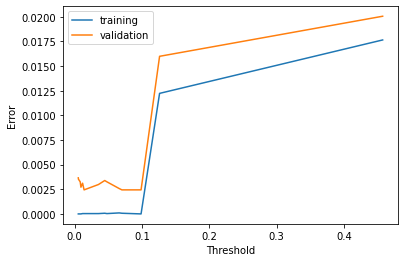

In [ ]:
  fig, ax = plt.subplots()
  ax.plot(thresholds, treshold_train_error, label='training')
  ax.plot(thresholds, treshold_val_error, label='validation')
  ax.set(xlabel='Threshold', ylabel='Error')
  ax.legend()  
  plt.show()

Best th: 0.013926399
current error : 0.002438693943910053


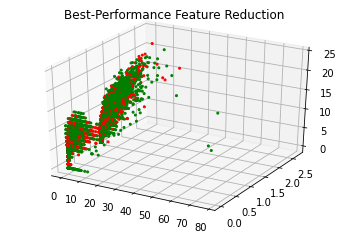

In [ ]:
  print('Best th:', best_th)
  print('current error :', current_error)

  
  #TODO plot best estimator
  colors=['green' if l==0 else 'red' for l in y_train]
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(best_transformation[:,0], best_transformation[:, 1], best_transformation[:, 2], s=4, alpha=1,color=colors)
  
  plt.title('Best-Performance Feature Reduction')
  plt.show()

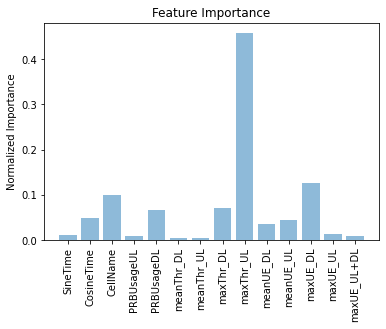

In [ ]:
  feature_importances = clf_GS.best_estimator_.named_steps["xgb_clf"].feature_importances_
  columns = ['SineTime', 'CosineTime', 'CellName', 'PRBUsageUL', 'PRBUsageDL', 'meanThr_DL', 'meanThr_UL', 'maxThr_DL', 'maxThr_UL', 'meanUE_DL', 'meanUE_UL', 'maxUE_DL', 'maxUE_UL', 'maxUE_UL+DL']

  fig = plt.figure() 
  plt.bar(np.arange(14) , feature_importances, align='center', alpha=0.5)
  plt.xticks(np.arange(14), columns, rotation='vertical')
  plt.ylabel('Normalized Importance')
  plt.title('Feature Importance')
  plt.show()

In [ ]:
  from sklearn.feature_selection import SelectFromModel
  #print(clf_GS.best_estimator_.named_steps["xgb_clf"].feature_importances_)
  #print(clf_GS.best_estimator_.named_steps["xgb_clf"].get_booster().get_fscore())
  # TODO plot de importancia features

  # thresholds = np.sort(clf_GS.best_estimator_.named_steps["xgb_clf"].feature_importances_)
  # print(thresholds)

  new_X_train = X_train
  selection = SelectFromModel(clf_GS.best_estimator_.named_steps["xgb_clf"], threshold=best_th , prefit=True)
  select_X_train = selection.transform(new_X_train)

  selection_model = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, n_jobs=10, verbose=1, cv=3, n_iter= 1)
  selection_model.fit(select_X_train, y_train)

  dump(clf_GS, 'best_th_feature_model.joblib')
  files.download('best_th_feature_model.joblib')

  pred_train = selection_model.predict(select_X_train)
  select_X_val = selection.transform(X_validation)
  pred_val = selection_model.predict(select_X_val)

  train_error = 1. - accuracy_score(y_train, pred_train)
  train_cmat = confusion_matrix(y_train, pred_train)
  val_error = 1. - accuracy_score(y_validation, pred_val)
  val_cmat = confusion_matrix(y_validation, pred_val)

  print("\nThreshold of value %f" % thresh)
  print("--------------------------------")
  print('\ntrain error: %f ' % train_error)
  print('train confusion matrix:')
  print(train_cmat)
  print('\ntest error: %f ' % val_error)
  print('test confusion matrix:')
  print(val_cmat)
  print("\n")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:   19.4s finished


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Threshold of value 0.452660
--------------------------------

train error: 0.000034 
train confusion matrix:
[[21376     1]
 [    0  8146]]

test error: 0.002439 
test confusion matrix:
[[5340    4]
 [  14 2023]]




In [ ]:
  #pred_test = clf_GS.predict(X_test)
  select_X_test = selection.transform(X_test)
  pred_test = selection_model.predict(select_X_test)

In [ ]:
if training == False:

  pred_train = clf_GS.predict(X_train)
  pred_val = clf_GS.predict(X_validation)

  print("TRAINING\n" + classification_report(y_train, pred_train))
  print("\nTESTING\n" + classification_report(y_validation, pred_val))

  train_error = 1. - accuracy_score(y_train, pred_train)
  train_cmat = confusion_matrix(y_train, pred_train)
  val_error = 1. - accuracy_score(y_validation, pred_val)
  val_cmat = confusion_matrix(y_validation, pred_val)

  print('train error: %f ' % train_error)
  print('train confusion matrix:')
  print(train_cmat)
  print('test error: %f ' % val_error)
  print('test confusion matrix:')
  print(val_cmat)

# Submission Formatting

In [ ]:
%%shell
# Create submission file if it does not exists
file=predictions.csv
if [ ! -e "$file" ] ; then
    touch anomaly-4G-detection/"$file"
fi

In [ ]:
# Create index column in data frame object
submission_dataframe = pd.DataFrame(np.arange(1, 9159), columns=['Id']) 

# Append predictions of test data as column
submission_dataframe['Label'] = pred_test

# Convert Data Frame object to CSV
submission_dataframe.to_csv('predictions.csv', index=False)

!mv predictions.csv anomaly-4G-detection/
predictions = pd.read_csv('anomaly-4G-detection/predictions.csv')
predictions

,Id,Label
0,1,1
1,2,0
2,3,0
3,4,0
4,5,1
...,...,...
9153,9154,0
9154,9155,1
9155,9156,0
9156,9157,0


In [ ]:
#!rm anomaly-4G-detection/predictions.csv

In [ ]:
#print(clf_GS.grid_scores_)

{}